In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sys

In [158]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from collections import Counter

In [15]:
import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [26]:
import numba
from itertools import combinations

In [27]:
import pandas as pd
import umap

In [28]:
@numba.njit()
def H_alpha_sparse_csr(arr_p,alpha=1.0):
    '''Calculate generalized entropy of order-alpha
        H_{\alpha}(\vec{p}) = \frac{1}{1-\alpha}( \sum_i p_i^{\alpha} - 1  )
        https://en.wikipedia.org/wiki/Tsallis_entropy

        INPUT:
        - arr_p, array (normalized probability distribution)
        optional
        - alpha, float (default:1.0 == Boltzmann-Shannon-Gibbs entropy)
        OUT:
        - H_alpha, float

        Note that we have to consider special cases 
        - alpha=0; if p_i=0: p_i^0=0 and p_i>0: p_i^0=1  
        - alpha=1; H --> -\sum_i p_i log(p_i) and 0*log(0) = 0
    '''
    ## consider only entries with p>0
    arr_p_pos = arr_p
    H = 0.0
    if alpha == 0.0:
        H = len(arr_p_pos) - 1
    elif alpha == 1.0:
        H = -np.sum(arr_p_pos*np.log(arr_p_pos))
    else:
        H = 1.0/(1.0-alpha)*(np.sum(arr_p_pos**alpha) - 1.0)
    return H

def D_alpha_sparse_csr(arr_p1, arr_p2, alpha=2.0,pi1=0.5,normalized=True):
    '''
    Generalized Jensen-Shannon divergence proposed in:
        Gerlach, Font-Clos, Altmann, Phys. Rev. X 6 (2016) 021009
        https://journals.aps.org/prx/abstract/10.1103/PhysRevX.6.021009

    quantifying the divergence between probability distributions p1 and p2

    INPUT:
    - p1, array  
    - p2, array
    optional
    - alpha, float (default:1)
    - pi1, float (default:0.5); weight given to p1 (pi2 = 1-pi1)
    - normalized (default:False); if True return normalized version of alpha-JSD

    OUTPUT:
    - JSD, float

    Note that p1 and p2 have to be defined over the SAME support, i.e.
    for any index i the probabilities p1[i] and p2[i] refer to the same symbol.
    If, for example a symbol j only appears in p1, then p1[j]>0 and p2[j]=0 (and vice versa)
    '''

    pi2 = 1.0-pi1

    H_1 = H_alpha_sparse_csr(arr_p1.data,alpha=alpha)
    H_2 = H_alpha_sparse_csr(arr_p2.data,alpha=alpha)
    arr_p12 = pi1*arr_p1 + pi2*arr_p2
    H_12 = H_alpha_sparse_csr(arr_p12.data,alpha=alpha)

    D = H_12 - pi1*H_1 - pi2*H_2

    if normalized == False:
        norm = 1.0
    else:
        norm = D_alpha_max(H_1,H_2,pi1,pi2,alpha=alpha)
    D /= norm
    return D

@numba.njit()
def D_alpha_max(H1,H2,pi1,pi2,alpha=1.0):
    '''The maximum Jensen-Shanon-divergence of two probability distributions p1 and p2
    with entropies H1 and H2 and weights pi1 and pi2.
    The maximum jsd is obtained by assuming the support of both distributions is disjunct.
    For more information see:
    Gerlach, Font-Clos, Altmann, Phys. Rev. X 6 (2016) 021009
    https://journals.aps.org/prx/abstract/10.1103/PhysRevX.6.021009

    INPUT:
    - H1, float, alpha-entropy of p1
    - H2, float, alpha-entropy of p2
    - pi1, float, weight given to p1
    - pi2, float, weight given to p2
    optional
    - alpha, float (default:1.0)

    OUTPUT:
    - D_max, float - maximum JSD
    '''
    D_max = 0.0
    if alpha == 1.0:
        D_max = -pi1*np.log(pi1)-pi2*np.log(pi2)
    else:
        D_max = (pi1**alpha-pi1)*H1+\
                (pi2**alpha-pi2)*H2+\
                1.0/(1.0-alpha)*(pi1**alpha+pi2**alpha-1)
    return D_max


In [118]:
_x = pd.read_pickle("tmpdata.p")

In [119]:
train_texts = _x["train_texts"]
train_labels = _x["train_labels"]
test_texts = _x["test_texts"]
test_labels = _x["test_labels"]
valid_texts = _x["valid_texts"]
valid_labels = _x["valid_labels"]

In [159]:
texts = []
labels = []
for text, label in zip(train_texts, train_labels):
    if len(text) > 4800 and Counter(text.split(" ")).most_common()[0][0] == "the":
        if label == 0 or np.random.uniform() < 0.1:
            texts.append(text)
            labels.append(label)

In [161]:
len(texts)

269

In [162]:
Counter(labels)

Counter({0: 218, 1: 51})

In [163]:
vect = CountVectorizer()

In [164]:
M = vect.fit_transform(texts)

In [165]:
num_docs = M.shape[0]
D = np.empty(shape=(num_docs, num_docs))

for i0, i1 in combinations(range(num_docs), 2):
    _d = D_alpha_sparse_csr(M[i0], M[i1], alpha=2)
    D[i0, i1] = _d
    D[i1, i0] = _d

In [166]:
proj = umap.UMAP(metric="precomputed")

In [167]:
x, y = proj.fit_transform(D).T

Text(0.5, 1.0, 'UMAP')

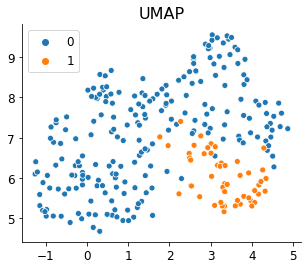

In [168]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.scatterplot(x, y, hue=labels)
ax.set_title("UMAP")
#ax.set_xlim(-30, -18)
#ax.set_ylim(-6, 0)

In [169]:
proj = TSNE()

In [170]:
x, y = proj.fit_transform(D).T

Text(0, 0.5, 'TSNE1')

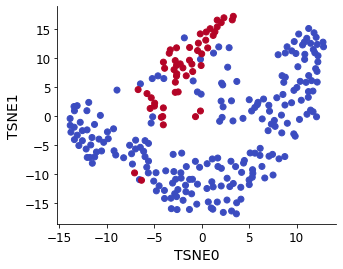

In [176]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.scatter(
    x, y,
    c=labels,
    cmap="coolwarm"
)
ax.set_xlabel("TSNE0")
ax.set_ylabel("TSNE1")

In [195]:
X = np.array([x, y]).T

In [196]:
from scipy.spatial.distance import pdist, squareform

In [228]:
J = (squareform(pdist(X)) < 5).astype(int) - np.identity(len(J))

In [229]:
import networkx as nx

In [230]:
G = nx.from_numpy_array(J)

/home/fontclos/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/fontclos/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


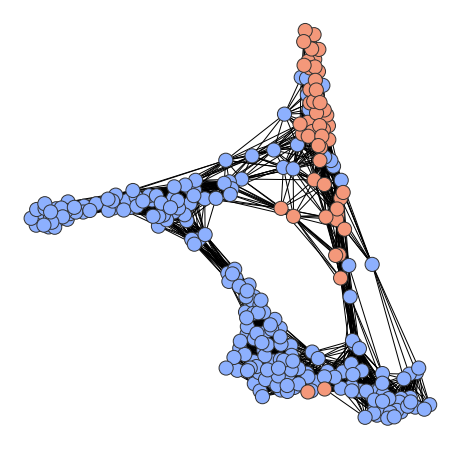

In [238]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_axis_off()
nx.draw_networkx(
    G,
    node_color=labels,
    with_labels=False,
    cmap="coolwarm",
    vmin=-0.5, vmax=1.5,
    node_size=200,
    ax=ax)
ax.collections[0].set_edgecolor("0.2") 
fig.savefig("../figures/gpt2-gutenberg-network.png", dpi=300)

In [ ]:
! mkdir ../figures